In [1]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo_mid import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset, get_train_test
from src.eval_mid import evaluate
from src.predict_mid import predict_image
from src.config import VOC_CLASSES, COLORS

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [4]:
load_network_path = None
pretrained = False

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.003
num_epochs = 1
batch_size = 20

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.3

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [6]:
train_dataset, test_dataset = get_train_test()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)

Initializing dataset
Initializing dataset


## Set up training tools

In [7]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Train detector



Starting epoch 1 / 1
Learning Rate for this epoch: 0.001
0 / 8163
Epoch [1/1], Iter [100/8163], Loss: total=223.636, reg=33.965, containing_obj=13.829, no_obj=33.077, cls=30.060
100 / 8163
Epoch [1/1], Iter [200/8163], Loss: total=207.354, reg=31.036, containing_obj=18.417, no_obj=16.538, cls=28.797
200 / 8163
Epoch [1/1], Iter [300/8163], Loss: total=197.773, reg=29.238, containing_obj=20.497, no_obj=11.026, cls=27.780
300 / 8163
Epoch [1/1], Iter [400/8163], Loss: total=196.871, reg=28.775, containing_obj=22.305, no_obj=8.269, cls=28.211
400 / 8163
Epoch [1/1], Iter [500/8163], Loss: total=192.901, reg=28.015, containing_obj=23.223, no_obj=6.615, cls=27.618
500 / 8163
Epoch [1/1], Iter [600/8163], Loss: total=190.633, reg=27.525, containing_obj=24.073, no_obj=5.513, cls=27.279
600 / 8163
Epoch [1/1], Iter [700/8163], Loss: total=189.055, reg=27.159, containing_obj=24.872, no_obj=4.725, cls=26.969
700 / 8163
Epoch [1/1], Iter [800/8163], Loss: total=188.348, reg=26.999, containing_o

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [1000/8163], Loss: total=186.173, reg=26.491, containing_obj=26.295, no_obj=3.308, cls=26.430
evaluating
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


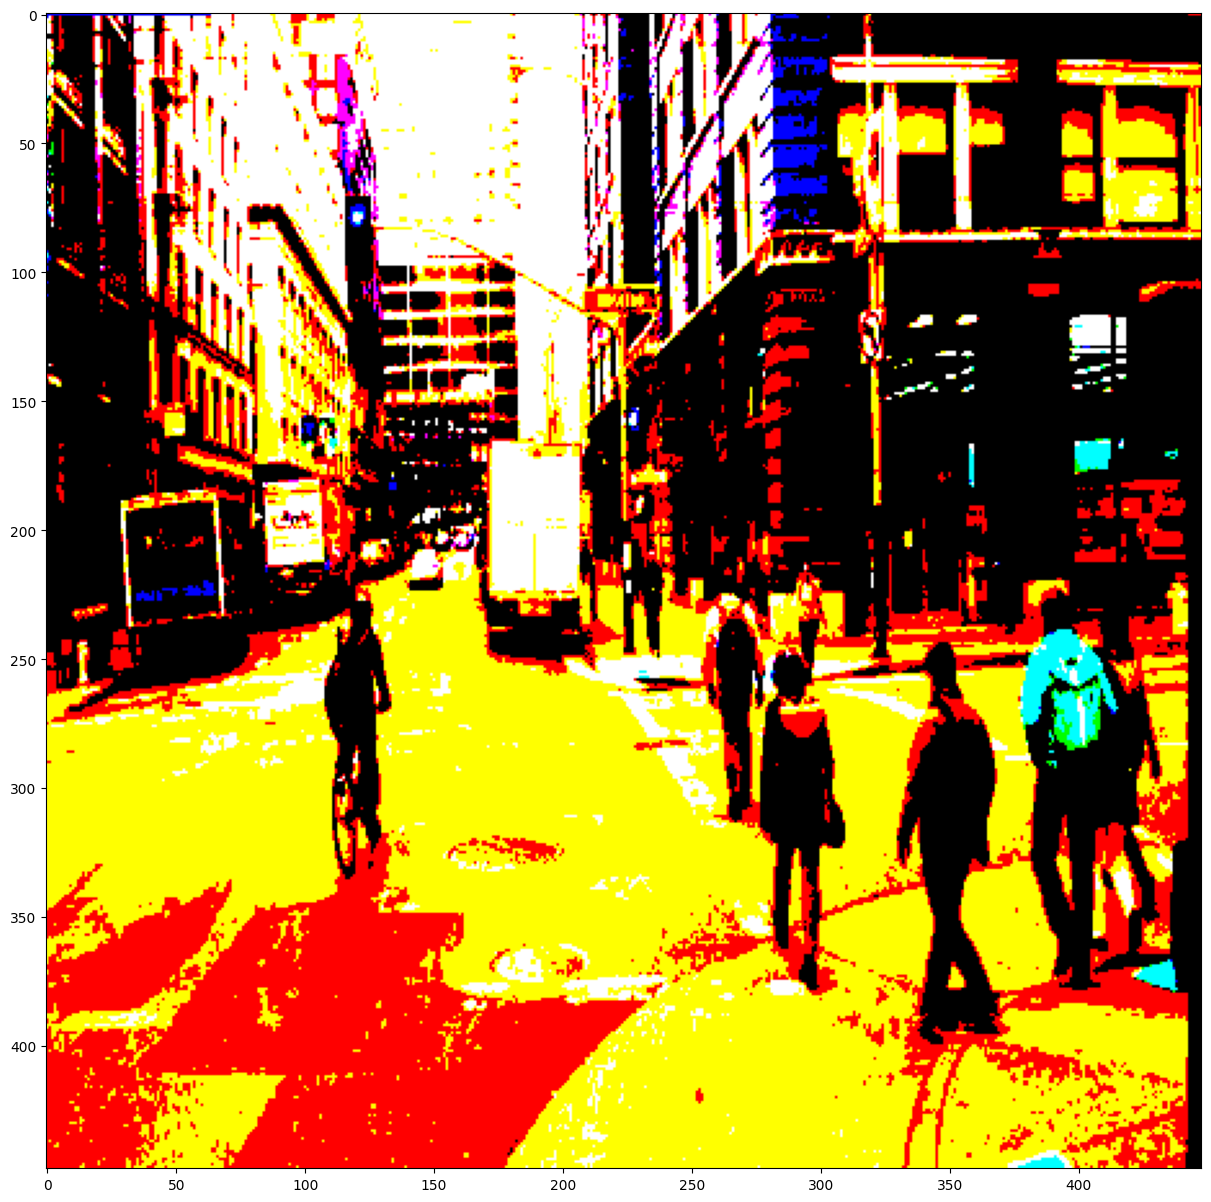

1000 / 8163
Epoch [1/1], Iter [1100/8163], Loss: total=185.627, reg=26.340, containing_obj=26.755, no_obj=3.007, cls=26.270
1100 / 8163
Epoch [1/1], Iter [1200/8163], Loss: total=184.456, reg=26.104, containing_obj=27.092, no_obj=2.756, cls=26.016
1200 / 8163
Epoch [1/1], Iter [1300/8163], Loss: total=183.798, reg=25.947, containing_obj=27.429, no_obj=2.544, cls=25.872
1300 / 8163
Epoch [1/1], Iter [1400/8163], Loss: total=183.210, reg=25.797, containing_obj=27.833, no_obj=2.363, cls=25.685
1400 / 8163
Epoch [1/1], Iter [1500/8163], Loss: total=182.450, reg=25.616, containing_obj=28.135, no_obj=2.205, cls=25.572
1500 / 8163
Epoch [1/1], Iter [1600/8163], Loss: total=181.646, reg=25.436, containing_obj=28.425, no_obj=2.067, cls=25.423
1600 / 8163
Epoch [1/1], Iter [1700/8163], Loss: total=180.945, reg=25.255, containing_obj=28.745, no_obj=1.946, cls=25.340
1700 / 8163
Epoch [1/1], Iter [1800/8163], Loss: total=180.452, reg=25.115, containing_obj=29.067, no_obj=1.838, cls=25.258
1800 / 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [2000/8163], Loss: total=178.937, reg=24.759, containing_obj=29.657, no_obj=1.654, cls=24.990
evaluating
predicting...
[[(0, 0), (0, 0), 'vehicle', 1, 0.0]]


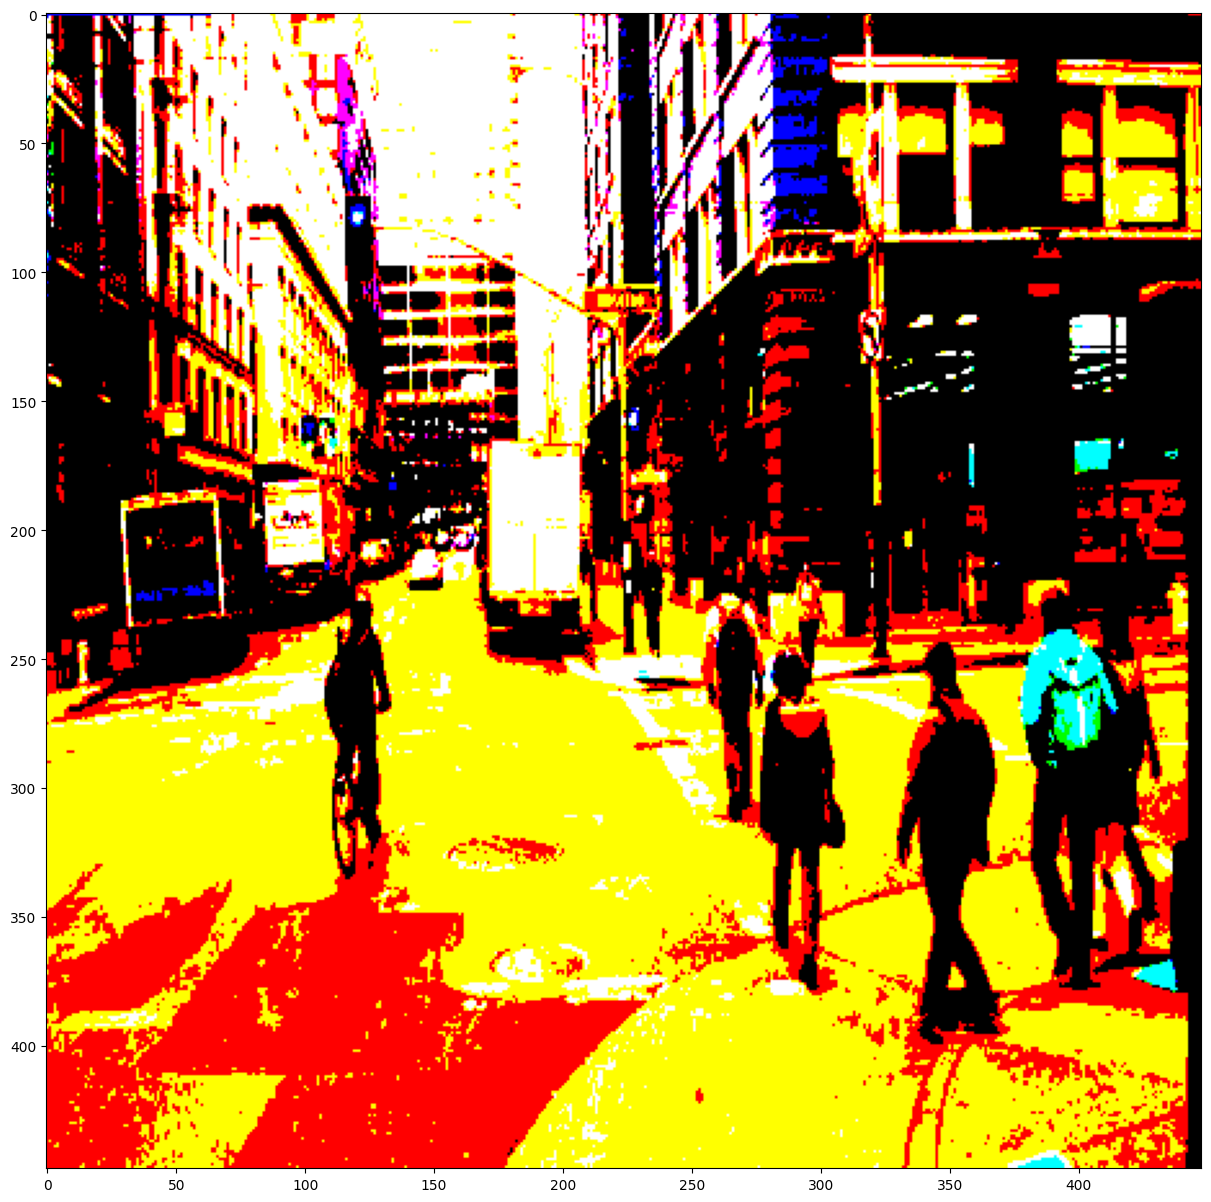

2000 / 8163
Epoch [1/1], Iter [2100/8163], Loss: total=178.068, reg=24.564, containing_obj=29.939, no_obj=1.575, cls=24.839
2100 / 8163
Epoch [1/1], Iter [2200/8163], Loss: total=177.420, reg=24.412, containing_obj=30.184, no_obj=1.557, cls=24.711
2200 / 8163
Epoch [1/1], Iter [2300/8163], Loss: total=176.402, reg=24.282, containing_obj=29.852, no_obj=1.947, cls=24.555
2300 / 8163
Epoch [1/1], Iter [2400/8163], Loss: total=175.173, reg=24.115, containing_obj=29.433, no_obj=2.430, cls=24.438
2400 / 8163
Epoch [1/1], Iter [2500/8163], Loss: total=173.843, reg=23.945, containing_obj=28.978, no_obj=2.916, cls=24.263
2500 / 8163
Epoch [1/1], Iter [2600/8163], Loss: total=172.696, reg=23.794, containing_obj=28.560, no_obj=3.411, cls=24.141
2600 / 8163
Epoch [1/1], Iter [2700/8163], Loss: total=171.419, reg=23.627, containing_obj=28.145, no_obj=3.868, cls=23.980
2700 / 8163
Epoch [1/1], Iter [2800/8163], Loss: total=170.134, reg=23.461, containing_obj=27.735, no_obj=4.337, cls=23.791
2800 / 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [3000/8163], Loss: total=167.882, reg=23.173, containing_obj=26.961, no_obj=5.201, cls=23.494
evaluating
predicting...
[[(321, 181), (355, 232), 'vehicle', 1, 0.13393986225128174], [(352, 180), (377, 230), 'vehicle', 1, 0.10719642788171768]]


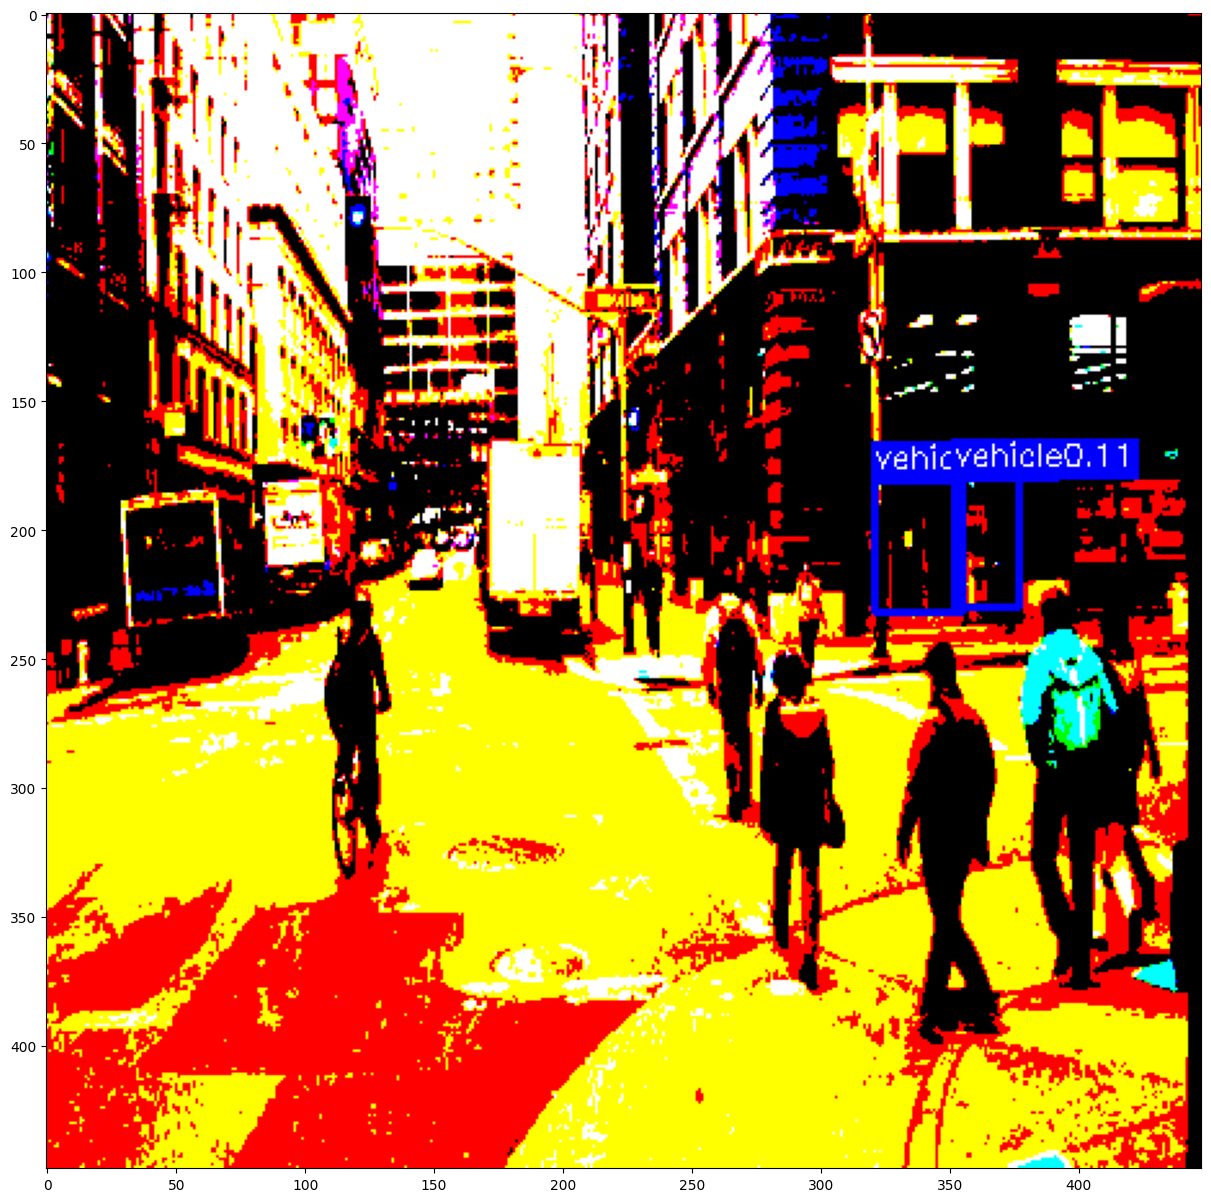

3000 / 8163
Epoch [1/1], Iter [3100/8163], Loss: total=166.680, reg=23.018, containing_obj=26.602, no_obj=5.563, cls=23.316
3100 / 8163
Epoch [1/1], Iter [3200/8163], Loss: total=165.388, reg=22.851, containing_obj=26.214, no_obj=5.956, cls=23.134
3200 / 8163
Epoch [1/1], Iter [3300/8163], Loss: total=164.285, reg=22.710, containing_obj=25.858, no_obj=6.327, cls=22.981
3300 / 8163
Epoch [1/1], Iter [3400/8163], Loss: total=163.182, reg=22.566, containing_obj=25.532, no_obj=6.679, cls=22.814
3400 / 8163
Epoch [1/1], Iter [3500/8163], Loss: total=162.027, reg=22.415, containing_obj=25.209, no_obj=6.999, cls=22.642
3500 / 8163
Epoch [1/1], Iter [3600/8163], Loss: total=160.960, reg=22.274, containing_obj=24.923, no_obj=7.306, cls=22.474
3600 / 8163
Epoch [1/1], Iter [3700/8163], Loss: total=159.946, reg=22.139, containing_obj=24.642, no_obj=7.604, cls=22.327
3700 / 8163
Epoch [1/1], Iter [3800/8163], Loss: total=159.069, reg=22.027, containing_obj=24.378, no_obj=7.895, cls=22.188
3800 / 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [4000/8163], Loss: total=157.275, reg=21.797, containing_obj=23.872, no_obj=8.418, cls=21.892
evaluating
predicting...
[[(321, 195), (352, 234), 'vehicle', 1, 0.1768815517425537], [(353, 195), (375, 230), 'vehicle', 1, 0.14981944859027863], [(430, 199), (442, 234), 'vehicle', 1, 0.12497138231992722], [(396, 200), (409, 232), 'vehicle', 1, 0.10940924286842346], [(326, 206), (342, 255), 'vehicle', 1, 0.10675958544015884], [(358, 214), (377, 254), 'vehicle', 1, 0.10567176342010498], [(15, 216), (32, 258), 'vehicle', 1, 0.10125578939914703]]


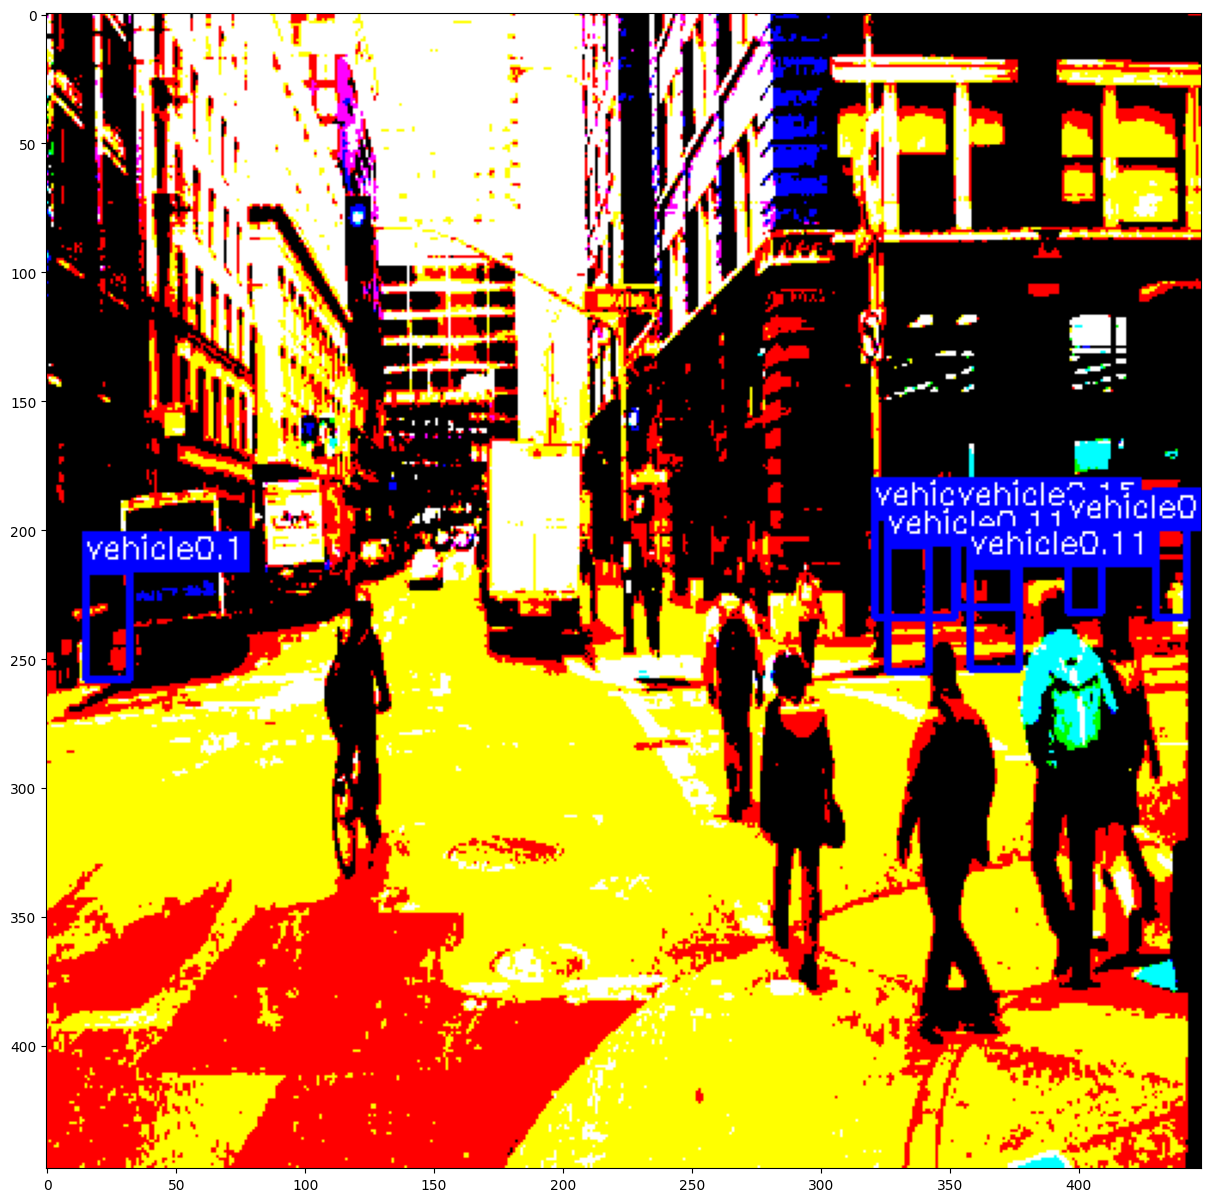

4000 / 8163
Epoch [1/1], Iter [4100/8163], Loss: total=156.468, reg=21.690, containing_obj=23.644, no_obj=8.664, cls=21.776
4100 / 8163
Epoch [1/1], Iter [4200/8163], Loss: total=155.780, reg=21.599, containing_obj=23.441, no_obj=8.904, cls=21.672
4200 / 8163
Epoch [1/1], Iter [4300/8163], Loss: total=155.065, reg=21.502, containing_obj=23.236, no_obj=9.151, cls=21.575
4300 / 8163
Epoch [1/1], Iter [4400/8163], Loss: total=154.315, reg=21.401, containing_obj=23.036, no_obj=9.363, cls=21.468
4400 / 8163
Epoch [1/1], Iter [4500/8163], Loss: total=153.602, reg=21.308, containing_obj=22.840, no_obj=9.564, cls=21.353
4500 / 8163
Epoch [1/1], Iter [4600/8163], Loss: total=152.986, reg=21.228, containing_obj=22.655, no_obj=9.768, cls=21.260
4600 / 8163
Epoch [1/1], Iter [4700/8163], Loss: total=152.400, reg=21.150, containing_obj=22.480, no_obj=9.960, cls=21.184
4700 / 8163
Epoch [1/1], Iter [4800/8163], Loss: total=151.790, reg=21.069, containing_obj=22.308, no_obj=10.139, cls=21.095
4800 / 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [5000/8163], Loss: total=150.528, reg=20.903, containing_obj=21.974, no_obj=10.461, cls=20.900
evaluating
predicting...
[[(319, 197), (353, 235), 'vehicle', 1, 0.13589462637901306], [(351, 197), (375, 230), 'vehicle', 1, 0.12534558773040771], [(109, 224), (141, 331), 'vehicle', 1, 0.11538538336753845], [(431, 200), (443, 234), 'vehicle', 1, 0.1070639118552208]]


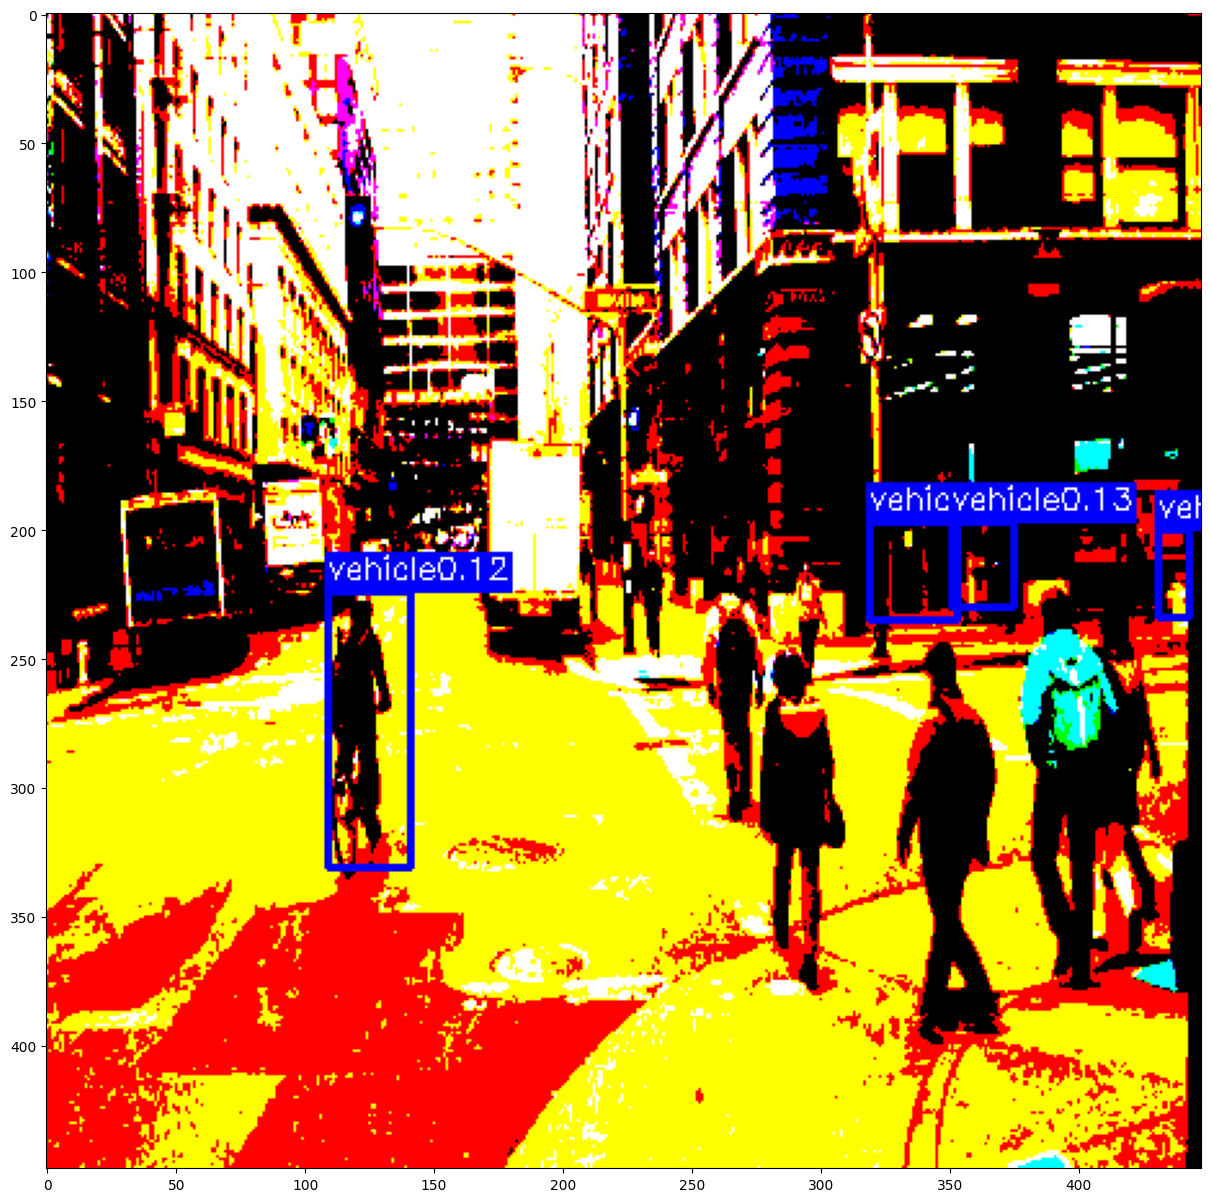

5000 / 8163
Epoch [1/1], Iter [5100/8163], Loss: total=150.019, reg=20.837, containing_obj=21.824, no_obj=10.616, cls=20.826
5100 / 8163
Epoch [1/1], Iter [5200/8163], Loss: total=149.574, reg=20.780, containing_obj=21.686, no_obj=10.778, cls=20.754
5200 / 8163
Epoch [1/1], Iter [5300/8163], Loss: total=149.032, reg=20.708, containing_obj=21.540, no_obj=10.927, cls=20.672
5300 / 8163
Epoch [1/1], Iter [5400/8163], Loss: total=148.469, reg=20.631, containing_obj=21.402, no_obj=11.062, cls=20.593
5400 / 8163
Epoch [1/1], Iter [5500/8163], Loss: total=147.980, reg=20.565, containing_obj=21.269, no_obj=11.196, cls=20.525
5500 / 8163
Epoch [1/1], Iter [5600/8163], Loss: total=147.498, reg=20.500, containing_obj=21.144, no_obj=11.323, cls=20.457
5600 / 8163
Epoch [1/1], Iter [5700/8163], Loss: total=146.940, reg=20.424, containing_obj=21.009, no_obj=11.448, cls=20.378
5700 / 8163
Epoch [1/1], Iter [5800/8163], Loss: total=146.604, reg=20.381, containing_obj=20.894, no_obj=11.580, cls=20.334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [6000/8163], Loss: total=145.730, reg=20.264, containing_obj=20.664, no_obj=11.810, cls=20.200
evaluating
predicting...
[[(320, 196), (353, 236), 'vehicle', 1, 0.1913749873638153], [(111, 223), (139, 332), 'vehicle', 1, 0.1691567450761795], [(352, 197), (375, 230), 'vehicle', 1, 0.15390898287296295], [(14, 219), (32, 256), 'vehicle', 1, 0.10316142439842224], [(395, 202), (407, 231), 'vehicle', 1, 0.10191117972135544]]


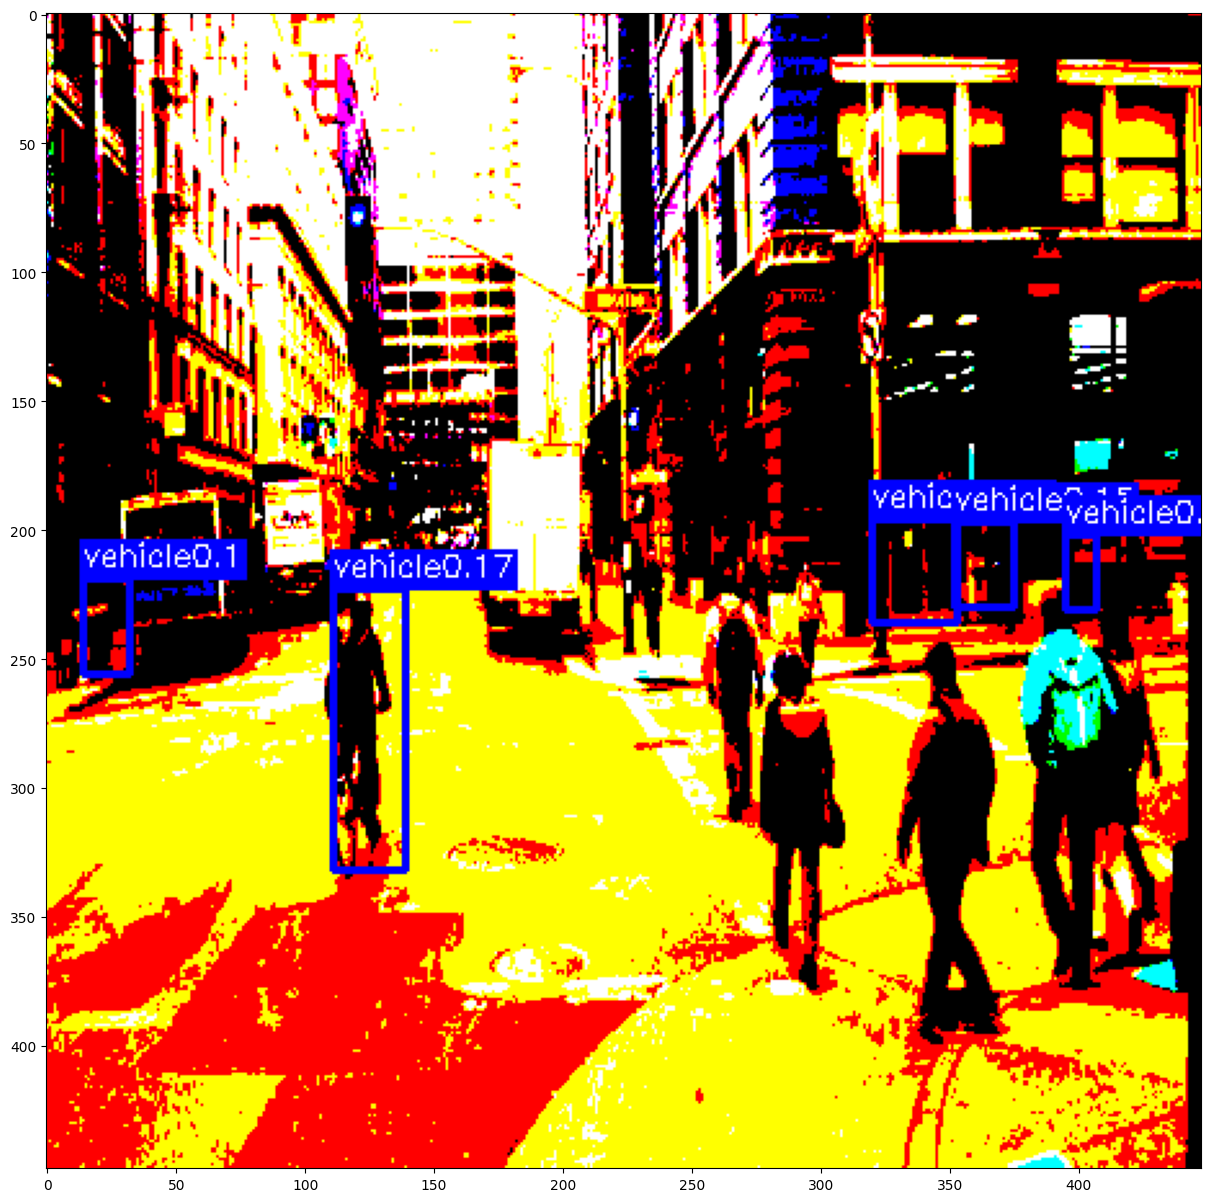

6000 / 8163
Epoch [1/1], Iter [6100/8163], Loss: total=145.289, reg=20.206, containing_obj=20.556, no_obj=11.916, cls=20.126
6100 / 8163
Epoch [1/1], Iter [6200/8163], Loss: total=144.903, reg=20.155, containing_obj=20.457, no_obj=12.026, cls=20.064
6200 / 8163
Epoch [1/1], Iter [6300/8163], Loss: total=144.516, reg=20.104, containing_obj=20.349, no_obj=12.133, cls=20.006
6300 / 8163
Epoch [1/1], Iter [6400/8163], Loss: total=144.213, reg=20.067, containing_obj=20.252, no_obj=12.235, cls=19.957
6400 / 8163
Epoch [1/1], Iter [6500/8163], Loss: total=143.849, reg=20.018, containing_obj=20.158, no_obj=12.343, cls=19.899
6500 / 8163
Epoch [1/1], Iter [6600/8163], Loss: total=143.510, reg=19.973, containing_obj=20.064, no_obj=12.439, cls=19.850
6600 / 8163
Epoch [1/1], Iter [6700/8163], Loss: total=143.177, reg=19.930, containing_obj=19.971, no_obj=12.538, cls=19.793
6700 / 8163
Epoch [1/1], Iter [6800/8163], Loss: total=142.835, reg=19.883, containing_obj=19.881, no_obj=12.627, cls=19.749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [7000/8163], Loss: total=142.100, reg=19.785, containing_obj=19.702, no_obj=12.793, cls=19.637
evaluating
predicting...
[[(321, 196), (353, 236), 'vehicle', 1, 0.17802399396896362], [(111, 223), (139, 333), 'vehicle', 1, 0.165403351187706], [(351, 197), (375, 230), 'vehicle', 1, 0.1569528877735138], [(15, 219), (32, 256), 'vehicle', 1, 0.10585185140371323], [(395, 202), (407, 231), 'vehicle', 1, 0.1015772894024849]]


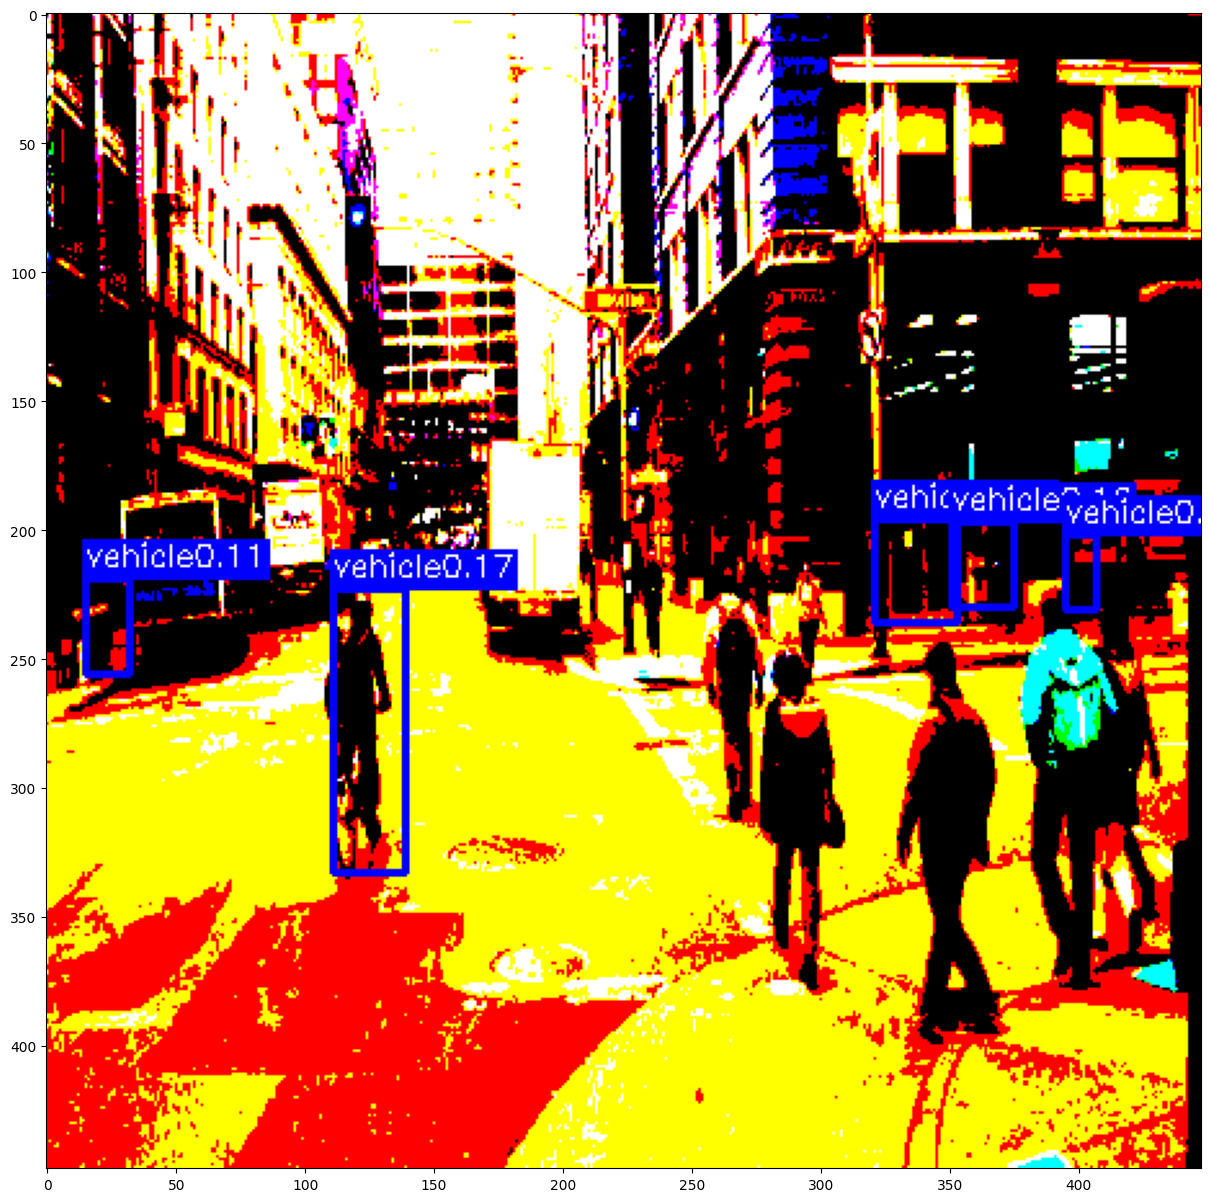

7000 / 8163
Epoch [1/1], Iter [7100/8163], Loss: total=141.815, reg=19.746, containing_obj=19.631, no_obj=12.871, cls=19.594
7100 / 8163
Epoch [1/1], Iter [7200/8163], Loss: total=141.592, reg=19.717, containing_obj=19.558, no_obj=12.963, cls=19.562
7200 / 8163
Epoch [1/1], Iter [7300/8163], Loss: total=141.272, reg=19.674, containing_obj=19.478, no_obj=13.040, cls=19.511
7300 / 8163
Epoch [1/1], Iter [7400/8163], Loss: total=140.975, reg=19.632, containing_obj=19.405, no_obj=13.115, cls=19.476
7400 / 8163
Epoch [1/1], Iter [7500/8163], Loss: total=140.796, reg=19.610, containing_obj=19.334, no_obj=13.185, cls=19.458
7500 / 8163
Epoch [1/1], Iter [7600/8163], Loss: total=140.470, reg=19.566, containing_obj=19.256, no_obj=13.252, cls=19.408
7600 / 8163
Epoch [1/1], Iter [7700/8163], Loss: total=140.222, reg=19.533, containing_obj=19.191, no_obj=13.319, cls=19.372
7700 / 8163
Epoch [1/1], Iter [7800/8163], Loss: total=139.995, reg=19.502, containing_obj=19.124, no_obj=13.389, cls=19.345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [1/1], Iter [8000/8163], Loss: total=139.539, reg=19.439, containing_obj=18.997, no_obj=13.523, cls=19.291
evaluating
predicting...
[[(321, 196), (353, 235), 'vehicle', 1, 0.1762157529592514], [(111, 223), (139, 333), 'vehicle', 1, 0.1722930669784546], [(351, 198), (375, 230), 'vehicle', 1, 0.1600358635187149], [(15, 220), (32, 255), 'vehicle', 1, 0.10590150952339172], [(395, 203), (407, 231), 'vehicle', 1, 0.10363681614398956]]


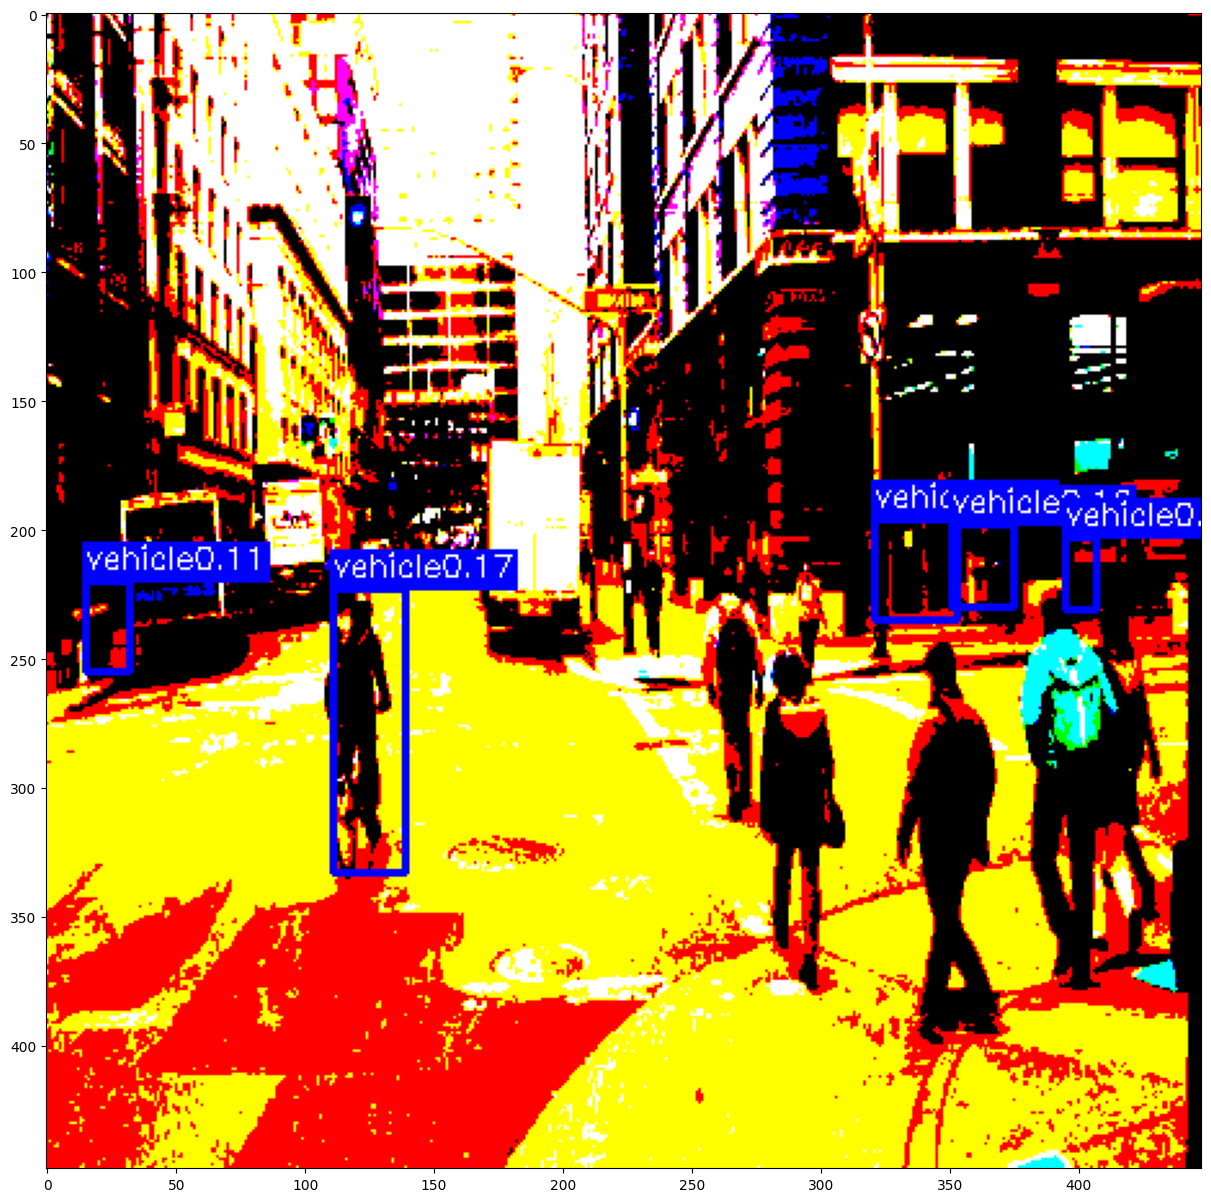

8000 / 8163
Epoch [1/1], Iter [8100/8163], Loss: total=139.351, reg=19.415, containing_obj=18.939, no_obj=13.592, cls=19.261
8100 / 8163


In [8]:
best_test_loss = np.inf
learning_rate = 0.001
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):


        if i == 3000 or i == 6000:
            learning_rate /= 10.0

            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate


        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map, dimg = data
        dimg = dimg.type(torch.FloatTensor).to('cuda')
        pred = net(images, dimg)
        if(i % 100 == 0):
            print(i, "/", len(train_loader))
        # print(pred[:, :, :, -20:])
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
        if (i+1) % 1000 == 0:
            print('evaluating')
            #test_aps = evaluate(net, test_loader)
            #print(epoch, test_aps)
            # with torch.no_grad():
            #     test_loss = collections.defaultdict(int)
            #     net.eval()
            #     for i, data in enumerate(test_loader):
            #         data = (item.to(device) for item in data)
            #         images, target_boxes, target_cls, has_object_map, dimg, bxs, lbls = data
                    
            #         pred = net(images, dimg)
            #         loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            #         for key in loss_dict:
            #             test_loss[key] += loss_dict[key].item()
            
            # outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(test_loader)))
            # outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in test_loss.items() )
            # print(outstring)
            # if best_test_loss > test_loss['total_loss']:
            #     best_test_loss = test_loss['total_loss']
            #     print('Updating best test loss: %.5f' % best_test_loss)
            #     torch.save(net.state_dict(),'checkpoints/best_detector_mid.pth')

            image_name = "test"
            image = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_cam_1.jpg', cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = cv2.resize(image, (448, 448)).astype(np.float64)

            dimg = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_depth_1.jpg', cv2.IMREAD_GRAYSCALE)
            
            dimg_small = torch.nn.MaxPool2d((4,4), stride=(4,4))(torch.unsqueeze(torch.unsqueeze(torch.tensor(dimg, dtype=torch.float), axis=0), axis=0)).repeat((1,3,1,1))
            dimg_small = dimg_small[0].permute(1,2,0).numpy()
            dimg_small = torch.Tensor(cv2.resize(dimg_small, (448, 448)))


            print('predicting...')
            result = predict_image(net, image, dimg_small, image_name=1)
            print(result)
            for left_up, right_bottom, class_name, _, prob in result:
                color = COLORS[VOC_CLASSES.index(class_name)]
                cv2.rectangle(image, left_up, right_bottom, color, 2)
                label = class_name + str(round(prob, 2))
                text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
                p1 = (left_up[0], left_up[1] - text_size[1])
                cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                            color, -1)
                cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

            plt.figure(figsize = (15,15))
            plt.imshow(image)
            plt.show()


        net.train()

    torch.save(net.state_dict(),'checkpoints/detector_mid.pth')
    


# View example predictions

predicting...
[[(108, 224), (129, 328), 'vehicle', 1, 0.14382407069206238]]


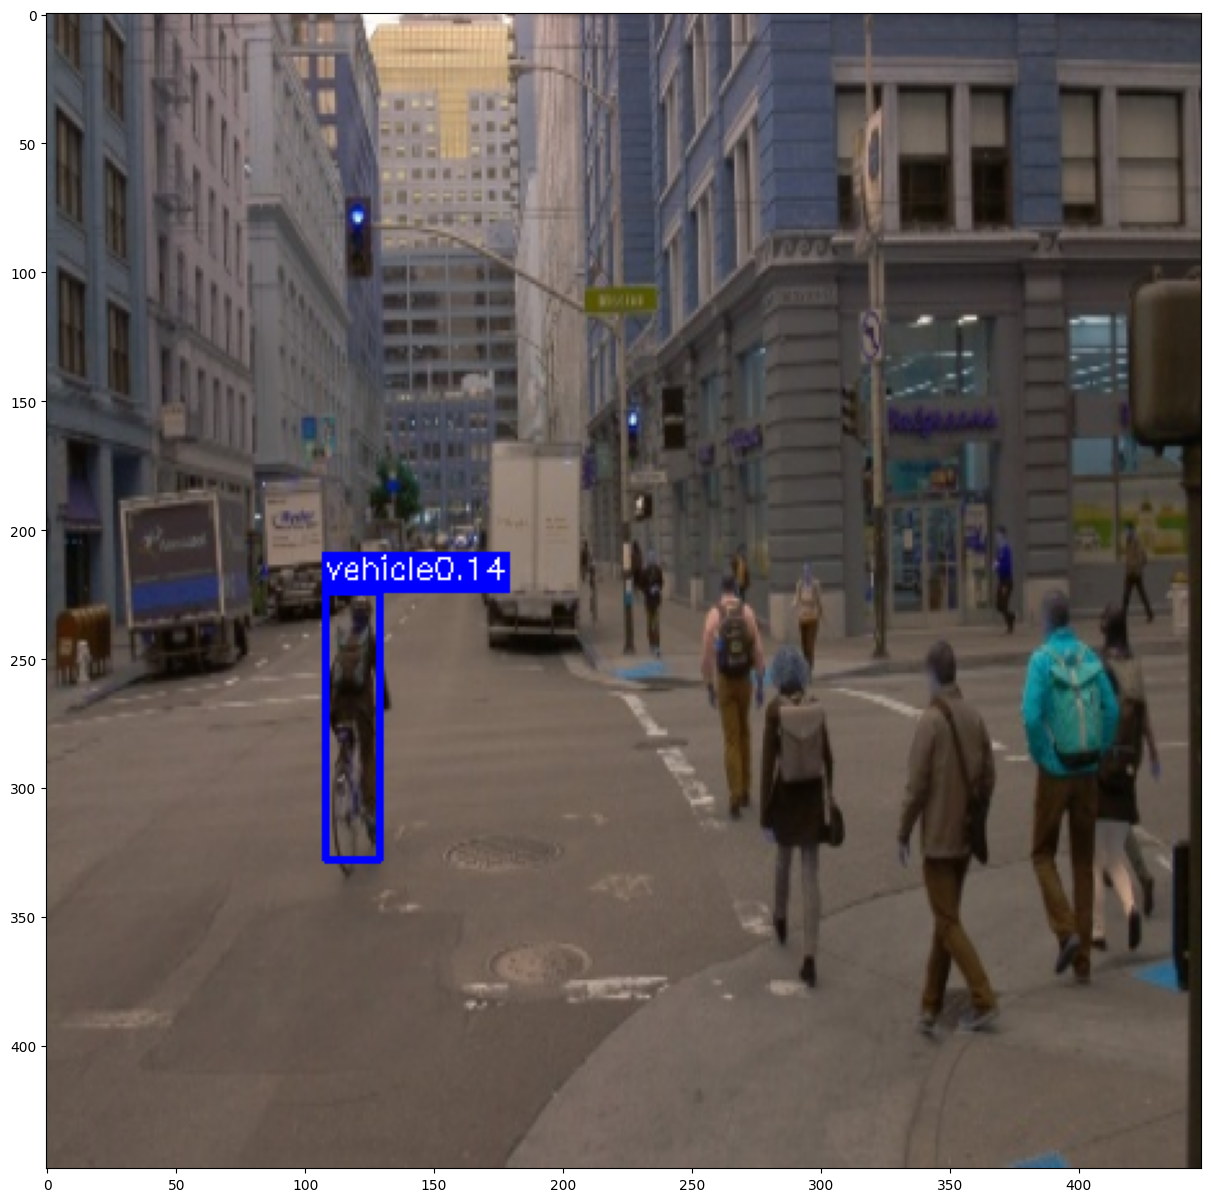

In [9]:
net.eval()

# select random image from test set
image_name = "test"
image = cv2.imread('/home/albyyuggle/Code/CS498/FP/data/30779396576054160_1880_000_1900_000/1557845072664263_cam_1.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (448, 448))

print('predicting...')
result = predict_image(net, image, image_name=1)
print(result)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [ ]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

### Cell added to get intermediate mAP values for students

In [ ]:
network_paths = ['detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test)


In [ ]:
output_submission_csv('my_new_solution.csv', test_aps)